In [ ]:
#!/usr/bin/env python
# coding: utf-8

import json, requests, time
from datetime import datetime
from shapely.geometry import Point
#See https://github.com/mocnik-science/osm-python-tools
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from shapely.geometry import Point, Polygon
from haversine import haversine, Unit


def fetchStations():
    """
    Fetch all station information in JSON format from the iRail API.

    Returns:
    dict: A JSON response containing all station information.
    """
    url = "https://api.irail.be/stations/?format=json&lang=en"
    headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}
    resp = requests.request('GET', url, headers=headers).json()
    return resp


def liveBoard(station):
    """
    Fetch the current time live board information of a station from the iRail API.
    
    Args:
    station (str): The name or ID of the station for which to retrieve live board information.
    
    Returns:
    dict: A JSON response containing the live board information of the specified station.
    """
    formatted_date = datetime.now().strftime("%d%m%y")
    formatted_time = datetime.now().strftime("%H%M")
    url = f"https://api.irail.be/liveboard/?station={station}&date={formatted_date}&time={formatted_time}&arrdep=departure&lang=en&format=json&alerts=true"
    headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}
    resp = requests.request('GET', url, headers=headers).json()
    return resp


def fetchTrainInfo(trainId):
    """
    Get the info of a specific train, including the stops
    
    Args:
    trainId (str): the id of the train
    
    Returns:
    dict: A JSON response containing the info of a specific train.
    """
    formatted_date = datetime.now().strftime("%d%m%y")
    formatted_time = datetime.now().strftime("%H%M")
    url = f"https://api.irail.be/vehicle/?id={trainId}&date={formatted_date}&format=json&lang=en&alerts=false"
    headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}
    resp = requests.request('GET', url, headers=headers).json()
    return resp


def fetchTrainComposition(trainId):
    """
    Fetch the composition information of a specific train.
    
    Args:
    trainId (str): The ID of the train for which to retrieve composition information.
    
    Returns:
    dict: A JSON response containing the composition information of the specified train.
    """
    url = f"https://api.irail.be/composition/?format=json&id={trainId}&data=all&lang=en"
    headers = {'Accept': 'application/json', 'Content-Type': 'application/json'}
    resp = requests.request('GET', url, headers=headers).json()
    return resp


def getStationIdByName(stationName):
    """
    Get the station ID from the name of the station.
    
    Args:
    stationName (str): The name of the station.
    
    Returns:
    str: The station ID corresponding to the provided station name.
    """
    stations = fetchStations()
    for station in stations['station']:
        if stationName in station['name']:
            return station['id']
        

def getStationAfter(currentTrainStationId, trainId):
    """
    Get the stops of a specific train after a specific stop.
    
    Args:
    currentTrainStationId (str): The ID of the train station after which you want to query the stops.
    trainId (str): The ID of the train.
    
    Returns:
    list: The station information after a specific train station.
    """
    stationAfter = []
    trainInfo = fetchTrainInfo(trainId)
    for i, stop in enumerate(trainInfo['stops']['stop']):
        #print(i, stop)
        #print(stop)
        #print(station['name'])
        if currentTrainStationId in stop['stationinfo']['id']:
            return [s['stationinfo'] for s in trainInfo['stops']['stop'][i+1:]]
        

def getStationLocationById(stationId):
    """
    Get the station's latitude and longitude by station ID.
    
    Args:
    stationId (str): The ID of the station.
    
    Returns:
    tuple: A tuple containing the latitude and longitude of the station.
    """
    stations = fetchStations()
    for station in stations['station']:
        if stationId in station['id']:
            return (float(station['locationY']), float(station['locationX']))


def havDistance(lat1, lon1, lat2, lon2):
    """
    Calculate haversine distance between two points.
    
    Args:
    lat1 (float): The latitude of the first point.
    lon1 (float): The longitude of the first point.
    lat2 (float): The latitude of the second point.
    lon2 (float): The longitude of the second point.
    
    Returns:
    float: The haversine distance in meters.
    """
    return haversine((lat1, lon1), (lat2, lon2), unit=Unit.METERS)


def inBoundaryCheck(lat, lon, pointList, rad=0.02):
    """
    Check if some point is in a boundary, used to find all the platform markers, signals within a specific station.
    
    Args:
    lat (float): The latitude of the center point.
    lon (float): The longitude of the center point.
    pointList (list): The list of the points in tuple, like [(x,y),(u,v),...].
    rad (float, optional): The distance between the boundary and the center point. Defaults to 0.02.
    
    Returns:
    list: A list of boolean values indicating whether each point is within the boundary.
    """
    # initiate a polygon with given vertices
    boundary_points = [(lat - rad, lon - rad),
                       (lat + rad, lon - rad),
                       (lat + rad, lon + rad),
                       (lat - rad, lon + rad)]
    #print('boundary_points', boundary_points)
    boundary_polygon = Polygon(boundary_points)
    #print('boundary_polygon', boundary_polygon)
    pointList = [Point(x, y) for x, y in pointList]
    #print('pointList', pointList)

    # check if in boundary
    boundaryCheck = [boundary_polygon.contains(point) for point in pointList]

    return boundaryCheck


def getOSMElement(elementType):
    """
    Get all the requested type of overpass elements (platform-markers, signals, etc.) using OpenStreetMap APIs.
    The OpenStreetMap API is wrapped by a library called "OSMPythonTools".
    
    Args:
    elementType (str): The kind of elements you want to get, such as "platform_marker", "signal".
    
    Returns:
    list: A list of elements.
    """
    nominatim = Nominatim()
    areaId = nominatim.query('Belgium').areaId()
    overpass = Overpass()
    query = overpassQueryBuilder(area=areaId, elementType='nwr', selector=f'"railway"="{elementType}"', includeGeometry=True)
    result = overpass.query(query)
    elements = result.elements()
    return elements


def getPlatformMarker(stationId, rad=0.02):
    """
    Get all platform markers in a station.
    
    Args:
    stationId (str): The ID of the station.
    rad (float, optional): The distance between the boundary and the center point. Defaults to 0.02.
    
    Returns:
    list: A list of OSM elements representing platform markers.
    """
    stationLocation = getStationLocationById(stationId)
    elements = getOSMElement('platform_marker')
    elemLocation = [(e.lat(), e.lon()) for e in elements]
    points = inBoundaryCheck(stationLocation[0], stationLocation[1], elemLocation, rad=rad)
    elemPMarker = [elements[i] for i in range(len(points)) if points[i]]
    return elemPMarker


def getSignal(stationId, rad=0.02):
    """
    Get all signals in a station.
    
    Args:
    stationId (str): The ID of the station.
    rad (float, optional): The distance between the boundary and the center point. Defaults to 0.02.
    
    Returns:
    list: A list of OSM elements representing signals.
    """
    stationLocation = getStationLocationById(stationId)
    elements = getOSMElement('signal')
    elemLocation = [(e.lat(), e.lon()) for e in elements]
    points = inBoundaryCheck(stationLocation[0], stationLocation[1], elemLocation, rad=rad)
    elemPMarker = [elements[i] for i in range(len(points)) if points[i]]
    return elemPMarker


def getNextTrainByTrack(stationId, trackNumber):
    """
    Get the next train info of a track.
    
    Args:
    stationId (str): The ID of the station.
    trackNumber (int): The number of track.
    
    Returns:
    dict or None: The next train info of a track if found, otherwise None.
    """
    departures = liveBoard(stationId)['departures']['departure']
    departure = None
    for dptr in departures:
        if dptr['platform'] == str(trackNumber):
            departure = dptr
            break
    return departure


def getPMarkerSignalByTrack(stationId, trackNumber, rad=0.015):
    """
    Fetch platform markers and signals for a specific track within a station.

    Args:
    stationId (str): The identifier of the station.
    trackNumber (str): The track number for which to fetch the data.
    rad (float, optional): The radius within which to search for markers and signals. Defaults to 0.015.

    Returns:
    tuple: A tuple containing two elements:
           - filteredPMs: A list of dictionaries, each representing a platform marker.
           - filteredSignals: A dictionary with lists of sorted signal dictionaries in 'forwards' and 'backwards' directions.
    """
    # Fetch all platform markers and signals within the specified radius of the station
    pms = getPlatformMarker(stationId, rad=rad)
    signals = getSignal(stationId, rad=rad)
    
    filteredPMs = []
    filteredSignals = []
    
    # Filter platform markers by track number
    for pm in pms:
        if 'ref:track' in pm.tags().keys() and pm.tags()['ref:track']==str(trackNumber):
            filteredPMs.append({'id'  :pm.id(),
                                'lat' :pm.lat(),
                                'lon' :pm.lon(),
                                'type':'platform_marker',
                                'tags':pm.tags()
                                })
    # Filter signals by track number
    for signal in signals:
        if 'ref:track' in signal.tags().keys() and signal.tags()['ref:track']==str(trackNumber):
            filteredSignals.append({'id'  :signal.id(),
                                    'lat' :signal.lat(),
                                    'lon' :signal.lon(),
                                    'type':'signal',
                                    'tags':signal.tags()
                                    })
    
    # Sort signals by direction
    forwards = [s for s in filteredSignals if s['tags']['railway:signal:direction'] == 'forward']
    backwards = [s for s in filteredSignals if s['tags']['railway:signal:direction'] == 'backward']
    
    # Sort signals by numerical reference if available
    if len(forwards) !=0:
        forwardsOnlyNumber = [s for s in forwards if s['tags']['ref'].isdigit()]
        sortedForwards = sorted(forwardsOnlyNumber, key=lambda x: int(x['tags']['ref']))
        
    if len(backwards) !=0:
        backwardsOnlyNumber = [s for s in backwards if s['tags']['ref'].isdigit()]
        sortedBackwards = sorted(backwardsOnlyNumber, key=lambda x: int(x['tags']['ref']))
    
    # Create a dictionary for sorted signals
    filteredSignals = {'forwards'  :  sortedForwards,
                       'backwards' : sortedBackwards}
    
    return filteredPMs, filteredSignals



def getStopSignal(trainStationId, trainId, trackNumber, rad=0.015):
    """
    Determine the appropriate stop signal for a train based on its current track and the direction to the next station.
    
    Args:
    trainStationId (str): ID of the current station.
    trainId (str): ID of the train.
    trackNumber (str): Track number on which the train is located.
    rad (float, optional): Radius to search for platform markers and signals. Default is 0.015.

    Returns:
    tuple: A tuple containing the selected stop signal and the direction of the track.
    direction : -1 if the train goes into the station from west to east, 1 if from east to west
    """
    # Retrieve platform markers and signals for the specified track
    filteredPMs, filteredSignals = getPMarkerSignalByTrack(trainStationId, trackNumber, rad=rad)
    # if it is a two-way track, there will be 2 sets of signals, one for forwards, another for backwards.
    # in this case we need to calculate which is the right one.
    if len(filteredSignals['forwards'])!=0 and len(filteredSignals['backwards'])!=0:
        #First we get the next train station.
        nextStation = getStationAfter(trainStationId, trainId)[0]
        #Calculate the distance from next train station to forwards' and backwards' last signal.
        lastForwards  = filteredSignals['forwards'][-1]
        lastBackwards = filteredSignals['backwards'][-1]
        distForwards  = havDistance(float(nextStation['locationY']), float(nextStation['locationX']), float(lastForwards['lat']),  float(lastForwards['lon']))
        distBackwards = havDistance(float(nextStation['locationY']), float(nextStation['locationX']), float(lastBackwards['lat']), float(lastBackwards['lon']))
        #The right one is the one has the smaller distance to next train
        correctSignals = filteredSignals['forwards'] if distForwards < distBackwards else filteredSignals['backwards']
        
    else:
        #If there is only 1 set of signals, then it is the right one
        correctSignals = filteredSignals['forwards'] if len(filteredSignals['forwards'])!=0 else filteredSignals['backwards']
    
    #based on the number of carriage of the train, we choose the corresponding signal to get stop location.
    composition = fetchTrainComposition(trainId)
    
    #Calculate total carriage number by adding different segments.
    totalCarriageNum = 0
    for sgmt in composition['composition']['segments']['segment']:
        totalCarriageNum = totalCarriageNum + int(sgmt['composition']['units']['number'])
        
    #print(f"totalCarriageNum1: {totalCarriageNum}")
    
    # Adjust carriage count for stopping purposes
    if totalCarriageNum % 2 != 0 and totalCarriageNum < 12: totalCarriageNum = totalCarriageNum+1
    if totalCarriageNum > 12: totalCarriageNum = 12
    
    #print(f"totalCarriageNum2: {totalCarriageNum}")
    # Find the signal corresponding to the number of carriages
    for signal in correctSignals:
        if int(signal['tags']['ref']) == totalCarriageNum:
            break
    stopSignal = signal
    
    # Sort signals from west to east to determine track direction
    sortedCorrectSignals = sort_points_west_to_east(correctSignals)
    direction = 1 if sortedCorrectSignals[0]['tags']['ref'] != '2' else -1
      
    return stopSignal, direction



def project_to_line(coordinates):
    """
    Project a list of latitude and longitude points onto a straight line based on their distances from the first point.
    
    Args:
    coordinates (list of dictionary): List of dictionary containing latitude, longitude information.
    
    Returns:
    coordinates: coordinates list, every coordinate has a newly added position key-value.
    """
    coordinates[0]['position'] = 0

    for point in coordinates[1:]:
        distance = havDistance(float(coordinates[0]['lat']), float(coordinates[0]['lon']), float(point['lat']), float(point['lon']))
        point['position'] = distance

    return coordinates


def sort_points_west_to_east(points):
    """
    Sort a list of points from west to east based on longitude.

    Args:
    points (list of dicts): List containing dictionaries with 'lat' and 'lon' keys.

    Returns:
    list of dicts: Sorted list of points from west to east.
    """
    sorted_points = sorted(points, key=lambda point: point['lon'])
    return sorted_points



def carriagesExtracted(composition):
    """
    Extract and enumerate all carriages from the train composition data structure.

    Args:
    composition (dict): A nested dictionary containing detailed information about a train's composition.

    Returns:
    list: A list of dictionaries, each representing a carriage with an additional 'No' key indicating its order.
    """
    carriages=[]
    numOfCarriage = 1
    for sgmt in composition['composition']['segments']['segment']:
        units = sgmt['composition']['units']['unit']
        for carriage in units:
            carriage['No'] = numOfCarriage
            carriages.append(carriage)
            numOfCarriage = numOfCarriage + 1
    return carriages

def calculate_car_positions(sortedPoints, carriages, direction):
    """
    Calculate the starting positions of each car based on the train direction.
    
    Args:
    sortedPoints: sorted and projected points, including platform markers, and stop signal.
    carriages: List of the lengths of each car.
    direction (int): Train direction, 1 for the train going into station from east to west, -1 for
    the train going into station from west to east.
    
    Returns:
    carriages: a list of carriages, each carriage is a dictionary adding position, type and isLocomotive Key-Value.
    sortedPlatformMarker: a list of sorted platform marker from west to east.
    """
    # Identify the stop signal from the sorted points
    for p in sortedPoints:
        if p['type'] == 'signal':
            stopSignal = p
            break
    # Initialize the first carriage's position, type, and locomotive status
    carriages[0]['position'] = stopSignal['position']
    carriages[0]['type'] = 'carriage'
    carriages[0]['isLocomotive'] = 1
    
    currentCar = carriages[0]
    # Calculate positions for all carriages based on the direction and the length of each carriage
    for i, car in enumerate(carriages):
        if i < len(carriages)-1:
            if direction == 1:
                # Calculate the next position if the direction is from east to west
                next_position = currentCar['position'] + float(car['lengthInMeter'])
            elif direction == -1:
                # Calculate the next position if the direction is from west to east
                next_position = currentCar['position'] - float(car['lengthInMeter'])
            # Assign calculated position, type, and locomotive status to the next carriage
            carriages[i+1]['position'] = next_position
            carriages[i+1]['type'] = 'carriage'
            carriages[i+1]['isLocomotive'] = 0
            currentCar = carriages[i+1]
    # Extract and sort platform markers from the sorted points      
    sortedPlatformMarker = [p for p in sortedPoints if p['type']== 'platform_marker']
    
    return carriages, sortedPlatformMarker

'''
def calculate_car_positions(sortedPoints, carriages, direction):
    """
    Calculate the starting positions of each car based on the train direction.
    
    Args:
    sortedPoints: sorted and projected points, including platform markers, and stop signal.
    stopSignal: The position of the train head, distance from the origin.
    carriages: List of the lengths of each car.
    direction (int): Train direction, 1 for west to east, -1 for east to west.
    
    Returns:
    list of int: Starting positions of each car from the train head.
    """
    for p in sortedPoints:
        if p['type'] == 'signal':
            stopSignal = p
            break
    
    carriages[0]['position'] = stopSignal['position']
    carriages[0]['type'] = 'carriage'
    carriages[0]['isLocomotive'] = 1
    
    currentCar = carriages[0]
    
    for i, car in enumerate(carriages):
        if i < len(carriages)-1:
            if direction == 1:
                next_position = currentCar['position'] + float(car['lengthInMeter'])
            elif direction == -1:
                next_position = currentCar['position'] - float(car['lengthInMeter'])
            carriages[i+1]['position'] = next_position
            carriages[i+1]['type'] = 'carriage'
            carriages[i+1]['isLocomotive'] = 0
            currentCar = carriages[i+1]
            
    sortedPlatformMarker = [p for p in sortedPoints if p['type']== 'platform_marker']
    
    return carriages, sortedPlatformMarker
'''


def getCarriagePlatformMarkerPosition(stationName ,trackNumber, rad = 0.015):
    """
    Calculate the positions of carriages and platform markers for a given station and track.

    Args:
    stationName (str): The name of the station.
    trackNumber (int): The number of the track at the station.
    rad (float, optional): The radius within which to search for markers and signals. Default is 0.015.

    Returns:
    tuple: A tuple containing a list of carriages with their positions, a list of sorted platform markers with their positions,
           and the direction of approach of the train. 1 for the train going into station from east to west, -1 for
           the train going into station from west to east.
    """
    # Retrieve the station ID based on the station name
    stationId = getStationIdByName(stationName)
    
    # Fetch the next train arriving at the specified track
    nextTrain = getNextTrainByTrack(stationId, 10)
    nexTrainId = nextTrain['vehicleinfo']['shortname']
    
    # Determine the stopping signal and the direction of the train
    stopSignal,  direction = getStopSignal(stationId, nexTrainId, trackNumber)
    
    # Fetch platform markers and signals for the track
    filteredPMs, filteredSignals = getPMarkerSignalByTrack(stationId, trackNumber, rad=rad)
    
    # Include the stop signal in the list of points to consider
    points = filteredPMs+[stopSignal]
    
    # Sort points from west to east to determine their order
    points = sort_points_west_to_east(points)
    
    # Project points onto a line to simplify positional calculations
    projectedPoints = project_to_line(points)
    
    # Fetch the composition of the train
    composition = fetchTrainComposition(nexTrainId)
    
    # Extract carriage information from the composition data
    carriages = carriagesExtracted(composition)
    
    # Calculate positions for each carriage based on the train's direction
    carriages, sortedPlatformMarker = calculate_car_positions(projectedPoints, carriages, direction)
    
    return carriages, sortedPlatformMarker, direction


def _C(function, *args, **kwargs):
    """
    Tries to execute a function with given arguments and keyword arguments up to 20 times if exceptions occur.

    Args:
    function (callable): The function to be executed.
    *args: Variable length argument list for the function.
    **kwargs: Arbitrary keyword arguments for the function.

    Returns:
    The result of the function if successful, None otherwise.
    """
    attempts = 0
    while attempts < 20:
        try:
            return function(*args, **kwargs)
        except Exception as e:
            attempts += 1
            print(f"Attempt {attempts}: {function.__name__} failed due to {e}")
            time.sleep(0.1)
            continue

    # If all attempts fail, print an error message
    print(f"Tried 20 times! {function.__name__} failed. Please check.")
    return None

In [20]:
#Now use the returns of this function to draw the picture
carriages, sortedPlatformMarker, direction = _C(getCarriagePlatformMarkerPosition, 'Brussels-North' ,7)
sortedCarAndPM = sorted(carriages+sortedPlatformMarker, key=lambda x: (x['position']))
print(sortedPlatformMarker)
print(carriages)
print(direction)
print(sortedCarAndPM)

[{'id': 11309165929, 'lat': 50.8594537, 'lon': 4.3613546, 'type': 'platform_marker', 'tags': {'level': '2', 'railway': 'platform_marker', 'ref': '7B', 'ref:track': '7'}, 'position': 0}, {'id': 11309165930, 'lat': 50.8600803, 'lon': 4.361635, 'type': 'platform_marker', 'tags': {'level': '2', 'railway': 'platform_marker', 'ref': '7B', 'ref:track': '7'}, 'position': 72.40110765161016}, {'id': 11309165931, 'lat': 50.8608102, 'lon': 4.3619616, 'type': 'platform_marker', 'tags': {'level': '2', 'railway': 'platform_marker', 'ref': '7A', 'ref:track': '7'}, 'position': 156.73752447876086}, {'id': 11309165932, 'lat': 50.8614604, 'lon': 4.3622526, 'type': 'platform_marker', 'tags': {'level': '2', 'railway': 'platform_marker', 'ref': '7A', 'ref:track': '7'}, 'position': 231.86610081893735}]
[{'id': '0', 'materialType': {'parent_type': 'AM08M', 'sub_type': 'c', 'orientation': 'LEFT'}, 'hasToilets': '1', 'hasSecondClassOutlets': '1', 'hasFirstClassOutlets': '1', 'hasHeating': '1', 'hasAirco': '1', '

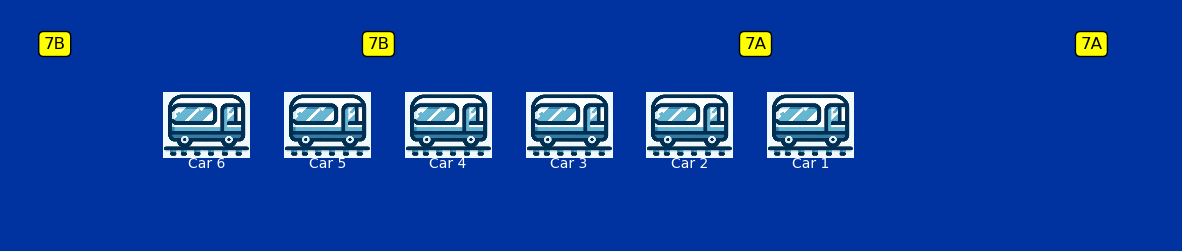

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Load the image of a train carriage
carriage_image_path = "c.png"  # Update the path if necessary

# Helper function to create an image box
def get_image_box(path, zoom=0.1):
    image = mpimg.imread(path)  # Changed to use mpimg.imread
    image_box = OffsetImage(image, zoom=zoom)
    return image_box

# Define data
data = sortedCarAndPM

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 3))
ax.set_xlim(-10, 250)
ax.set_ylim(0, 3)
ax.axis('off')

# Set the background color for the entire figure
fig.patch.set_facecolor('#0033A0')
ax.set_facecolor('#0033A0')  # Ensure the axis background is also blue

# Plotting the carriages and platform markers
for item in data:
    if item['type'] == 'platform_marker':
        ax.text(item['position'], 2.5, item['tags']['ref'], ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='yellow'))
    elif item['type'] == 'carriage':
        # Create an image box for the carriage
        image_box = get_image_box(carriage_image_path, zoom=0.15)
        ab = AnnotationBbox(image_box, (item['position'] + 10, 1.5), frameon=False)
        ax.add_artist(ab)
        ax.text(item['position'] + 10, 1, f'Car {item["No"]}', ha='center', va='center', color='white', fontsize=10)

# Show the plot
plt.show()
